In [10]:
import matplotlib.pyplot as plt

import utils.basic_utils as bu
import utils.funcs as fn
import utils.image_utils as imu
import utils.selection as sel
from utils.paths import ROOT
from utils.keywords import *
from utils.common_types import *

In [11]:
RANDOM_SEARCH = 'random_search2'

In [12]:
# def best_random_search(metric, sigma=None, p=None, zoom=None) -> NumpyArray:
    
#     if sigma is not None:
#         PROCESS = DENOISING
#     elif p is not None:
#         PROCESS = INPAINTING
#     elif zoom is not None:
#         PROCESS = SR
    
#     folder = ROOT[RANDOM_SEARCH][PROCESS]
#     if PROCESS == DENOISING:
#         folder = folder[sigma]
#     elif PROCESS == INPAINTING:
#         folder = folder[p]
#     elif PROCESS == SR:
#         folder = folder[zoom]
#     folder = folder[img_stem]
    
#     chosen_models = folder[f'{metric}_chosen_models.csv']
#     chosen_models = chosen_models.load()
#     chosen_models = chosen_models.sort_values(by='psnr smooth', ascending=False)

#     best_model = chosen_models.iloc[0].name
    
#     restored_img = folder[best_model][f'{metric}_out.png'].load()
    
#     return restored_img

def isnasdip_selected(img_stem, metric, sigma=None, p=None, zoom=None, best=False) -> NumpyArray:
    
    PROCESS = bu.get_process(sigma, p, zoom)
    gt = bu.read_true_image(PROCESS, img_stem)
    if PROCESS == DENOISING:
        iter = 2000
    elif PROCESS == INPAINTING:
        iter = 9500
    elif PROCESS == SR:
        iter = 5000
    
    folder = ROOT[RANDOM_SEARCH][PROCESS]
    if PROCESS == DENOISING:
        folder = folder[sigma]
    elif PROCESS == INPAINTING:
        folder = folder[p]
        
        if not folder[img_stem].exists():
            folder = folder['prev_set12_7k']
            
    elif PROCESS == SR:
        folder = folder[zoom]
    folder = folder[img_stem]
    
    
    try:
        chosen_models = folder[f'{metric}_chosen_models.csv']
        chosen_models = chosen_models.load()
    except FileNotFoundError:
        chosen_models = folder[iter][f'{metric}_chosen_models.csv']
        chosen_models = chosen_models.load()
        
    chosen_models = chosen_models.sort_values(by='psnr smooth', ascending=False)
    
    model_names = chosen_models.index
    model_metrics = {name: chosen_models.loc[name][metric] for name in model_names}
    
    try:
        model_outputs = {name: folder[name][f'{metric}_out.png'].load() for name in model_names}
    except FileNotFoundError:
        model_outputs = {name: folder[iter][name][f'{metric}_out.png'].load() for name in model_names}
    
    if PROCESS == SR and gt.shape[0] == 3:
        ycbcr = True
    else:
        ycbcr = False

    if best:
        selected_model = sel.closest_to(model_outputs, gt, ycbcr=ycbcr)
    else:
        selected_model = sel.closest_to_average(model_outputs, model_metrics, ycbcr=ycbcr)
    
    out = model_outputs[selected_model]
    
    return out

def get_nasdip_image(sigma=None, p=None, zoom=None) -> NumpyArray:
    
    if sigma is not None:
        PROCESS = DENOISING
    elif p is not None:
        PROCESS = INPAINTING
    elif zoom is not None:
        PROCESS = SR
    
    folder = ROOT[BENCHMARK][PROCESS]
    if PROCESS == DENOISING:
        folder = folder[sigma]
    elif PROCESS == INPAINTING:
        folder = folder[p]
    elif PROCESS == SR:
        folder = folder[zoom]
    folder = folder[img_stem][DATA]
    
    htr = folder['best_0'][HTR_PKL].load()
    out = htr['outs'][1200]
    
    return out

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

noisy 0.2917094430923709
dip 0.8754425392326072
nasdip 0.8804467932149646
isnasdip 0.8763804170976953


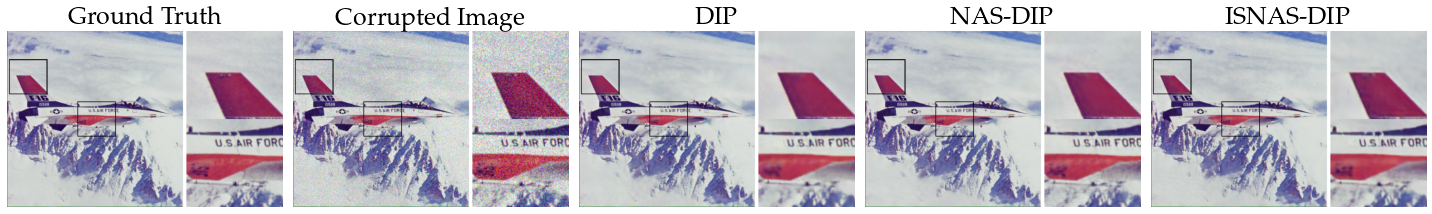

In [15]:
img_stem = 'f16_512_rgb'
sigma = 25
p = 50
zoom = 8

# metric = 'psd db strip mse'
metric = 'psd strip hist emd'

gt_img = bu.read_true_image(DENOISING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, sigma=sigma)
dip_img = ROOT['NASDIP Official Results'][DENOISING][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][DENOISING][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, sigma=25)

from skimage.metrics import structural_similarity as ssim
print('noisy', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(ns_img, 0, -1), 
    data_range=(ns_img.max() - ns_img.min()),
    multichannel=True
))
print('dip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(dip_img, 0, -1), 
    data_range=(dip_img.max() - dip_img.min()),
    multichannel=True
))
print('nasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(nasdip_img, 0, -1), 
    data_range=(nasdip_img.max() - nasdip_img.min()),
    multichannel=True
))
print('isnasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(isnasdip_img, 0, -1), 
    data_range=(isnasdip_img.max() - isnasdip_img.min()),
    multichannel=True
))

# try:
#     nasdip_img = get_nasdip_image(sigma=sigma, p=p, zoom=zoom)
# except:
    
fig, axs = plt.subplots(1, 5)
axs = axs.reshape((-1,))

imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.16, 0.01),
    top_left2=(0.4, 0.4),
    size=(0.2, 0.22),
    titles=['Ground Truth', 'Corrupted Image', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs,
    fontsize=25,
    location='right',
    sep_px=10,
    sep_color='white'
)
# plt.suptitle('Qualitative Comparison')
# plt.rcParams["figure.figsize"] = (12, 18)
# plt.tight_layout()
fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-f16.png', facecolor='white', 
#     bbox_inches='tight'
# )

noisy 0.5896560246375377
dip 0.7562547865447518
nasdip 0.8009560374707675
isnasdip 0.7008640325299403


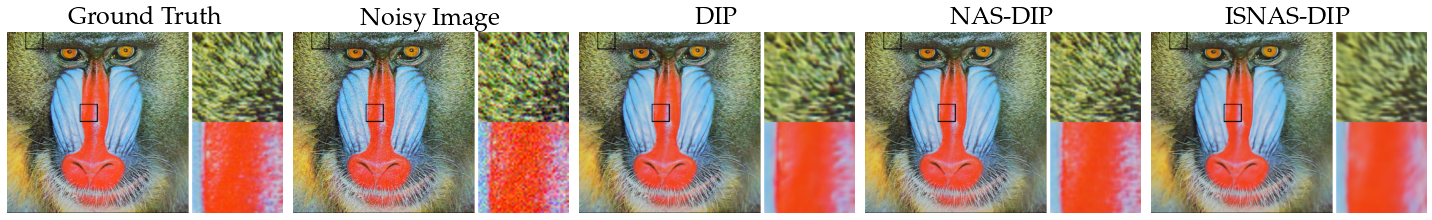

In [16]:
img_stem = 'baboon_512_rgb'
sigma = 25
p = 50
zoom = 8

metric = 'psd db strip mse'
# metric = 'psd strip hist emd'

gt_img = bu.read_true_image(DENOISING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, sigma=sigma)
dip_img = ROOT['NASDIP Official Results'][DENOISING][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][DENOISING][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, sigma=25)

from skimage.metrics import structural_similarity as ssim
print('noisy', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(ns_img, 0, -1), 
    data_range=(ns_img.max() - ns_img.min()),
    multichannel=True
))
print('dip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(dip_img, 0, -1), 
    data_range=(dip_img.max() - dip_img.min()),
    multichannel=True
))
print('nasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(nasdip_img, 0, -1), 
    data_range=(nasdip_img.max() - nasdip_img.min()),
    multichannel=True
))
print('isnasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(isnasdip_img, 0, -1), 
    data_range=(isnasdip_img.max() - isnasdip_img.min()),
    multichannel=True
))

# try:
#     nasdip_img = get_nasdip_image(sigma=sigma, p=p, zoom=zoom)
# except:
    
fig, axs = plt.subplots(1, 5)
axs = axs.reshape((-1,))

imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0, 0.10),
    top_left2=(0.4, 0.4),
    size=(0.1, 0.1),
    titles=['Ground Truth', 'Noisy Image', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs,
    fontsize=25,
    location='right',
    sep_px=10,
    sep_color='white'
)
# plt.suptitle('Qualitative Comparison')
# plt.rcParams["figure.figsize"] = (12, 18)
# plt.tight_layout()
fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-baboon.png', facecolor='white', 
#     bbox_inches='tight'
# )

bic 0.5564101965945865
dip 0.847101680978363
nasdip 0.8809804955629433
isnasdip 0.8785133993286803


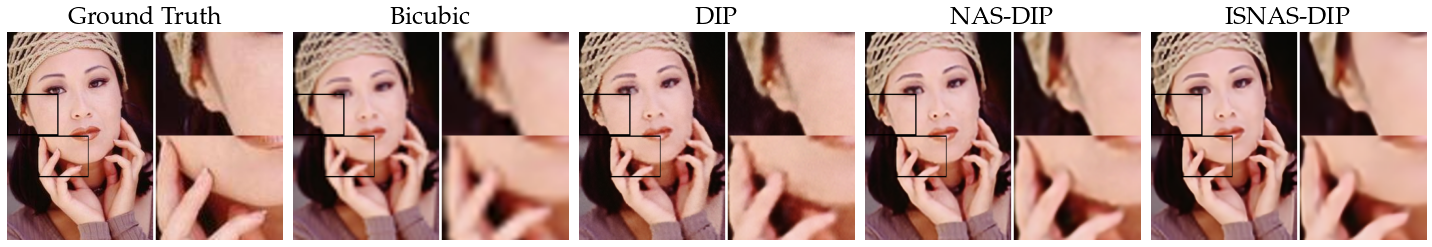

In [23]:
img_stem = 'woman_rgb'
sigma = 25
p = 50
zoom = 4

# metric = 'psd db strip mse'
# metric = 'psd strip hist emd'
metric = 'psd db mse'

gt_img = bu.read_true_image(SR, img_stem)
bic_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom]['bicubic'][f'{img_stem}.png'].load()
bic_img = imu.resize(bic_img, (gt_img.shape[1], gt_img.shape[2]))

dip_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, zoom=zoom)

from skimage.metrics import structural_similarity as ssim
print('bic', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(bic_img, 0, -1), 
    data_range=(bic_img.max() - bic_img.min()),
    multichannel=True
))
print('dip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(dip_img, 0, -1), 
    data_range=(dip_img.max() - dip_img.min()),
    multichannel=True
))
print('nasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(nasdip_img, 0, -1), 
    data_range=(nasdip_img.max() - nasdip_img.min()),
    multichannel=True
))
print('isnasdip', ssim(
    np.moveaxis(gt_img, 0, -1), np.moveaxis(isnasdip_img, 0, -1), 
    data_range=(isnasdip_img.max() - isnasdip_img.min()),
    multichannel=True
))

# try:
#     nasdip_img = get_nasdip_image(sigma=sigma, p=p, zoom=zoom)
# except:
    
fig, axs = plt.subplots(1, 5)
axs = axs.reshape((-1,))

imu.qualitative_comparison(
    [gt_img, bic_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.3, 0),
    top_left2=(0.5, 0.21),
    size=(0.2, 0.35),
    titles=['Ground Truth', 'Bicubic', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs,
    fontsize=25,
    location='right',
    sep_px=4,
    sep_color='white'
)
# plt.suptitle('Qualitative Comparison')
# plt.rcParams["figure.figsize"] = (12, 18)
# plt.tight_layout()
fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-woman.png', facecolor='white', 
#     bbox_inches='tight'
# )

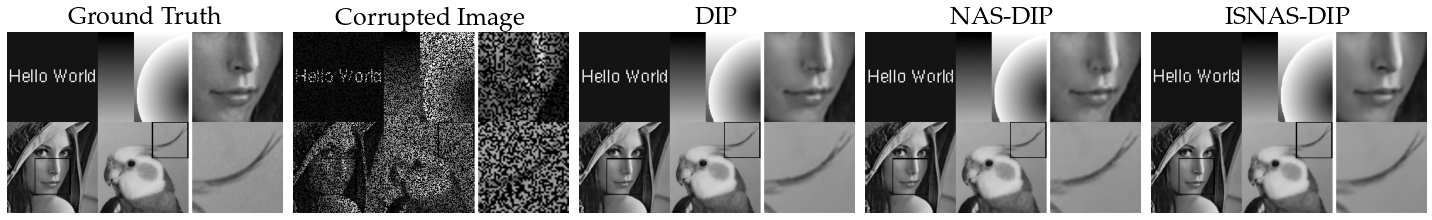

In [18]:
img_stem = 'montage_256'
sigma = 25
p = 50
zoom = 4

# metric = 'psd db strip mse'
metric = 'psd strip hist emd'

gt_img = bu.read_true_image(INPAINTING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, p=p)

dip_img = ROOT['NASDIP Official Results'][INPAINTING][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][INPAINTING][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, p=p)

# try:
#     nasdip_img = get_nasdip_image(sigma=sigma, p=p, zoom=zoom)
# except:

fig, axs = plt.subplots(1, 5)
axs = axs.reshape((-1,))

imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.7, 0.15),
    top_left2=(0.5, 0.80),
    size=(0.2, 0.2),
    titles=['Ground Truth', 'Corrupted Image', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs,
    fontsize=25,
    location='right',
    sep_px=5,
    sep_color='white'
)
# plt.suptitle('Qualitative Comparison')
# plt.rcParams["figure.figsize"] = (12, 18)
# plt.tight_layout()
fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-montage.png', facecolor='white', 
#     bbox_inches='tight'
# )

(3, 512, 768)


TypeError: qualitative_comparison() got multiple values for argument 'top_left1'

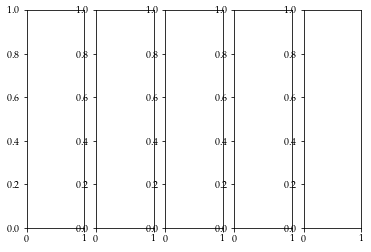

In [19]:
img_stem = 'kodim01_rgb'
img_stem_official = 'kodim01_rgb'
dataset = 'set14'
sigma = 25
p = 50
zoom = 4

# metric = 'psd db strip mse'
# metric = 'psd strip hist emd'
metric = 'psd db mse'

gt_img = bu.read_true_image(DENOISING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, sigma=sigma)

print(gt_img.shape)

dip_img = ROOT['NASDIP Official Results'][DENOISING][DIP][f'{img_stem_official}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][DENOISING][NASDIP][f'{img_stem_official}.png'].load()
# htr = ROOT[BENCHMARK][DENOISING][sigma][img_stem][DATA][BEST][HTR_PKL].load()
# nasdip_img = htr['best_out_sm']

isnasdip_img = isnasdip_selected(img_stem, metric, sigma=sigma, best=True)

# try:
#     nasdip_img = get_nasdip_image(sigma=sigma, p=p, zoom=zoom)
# except:
    
fig, axs = plt.subplots(1, 5)
axs = axs.reshape((-1,))

imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    ['Ground Truth', 'Noisy Image', 'DIP', 'NASDIP', 'ISNAS-DIP'],
    top_left1=(0.50, 0.02),
    top_left2=(0, 0.41),
    size=(0.20, 0.15),
    axs=axs,
    fontsize=25,
    location='right'
)
# plt.suptitle('Qualitative Comparison')
# plt.rcParams["figure.figsize"] = (12, 18)
# plt.tight_layout()
fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-kodim01-1.png', facecolor='white', 
#     bbox_inches='tight'
# )

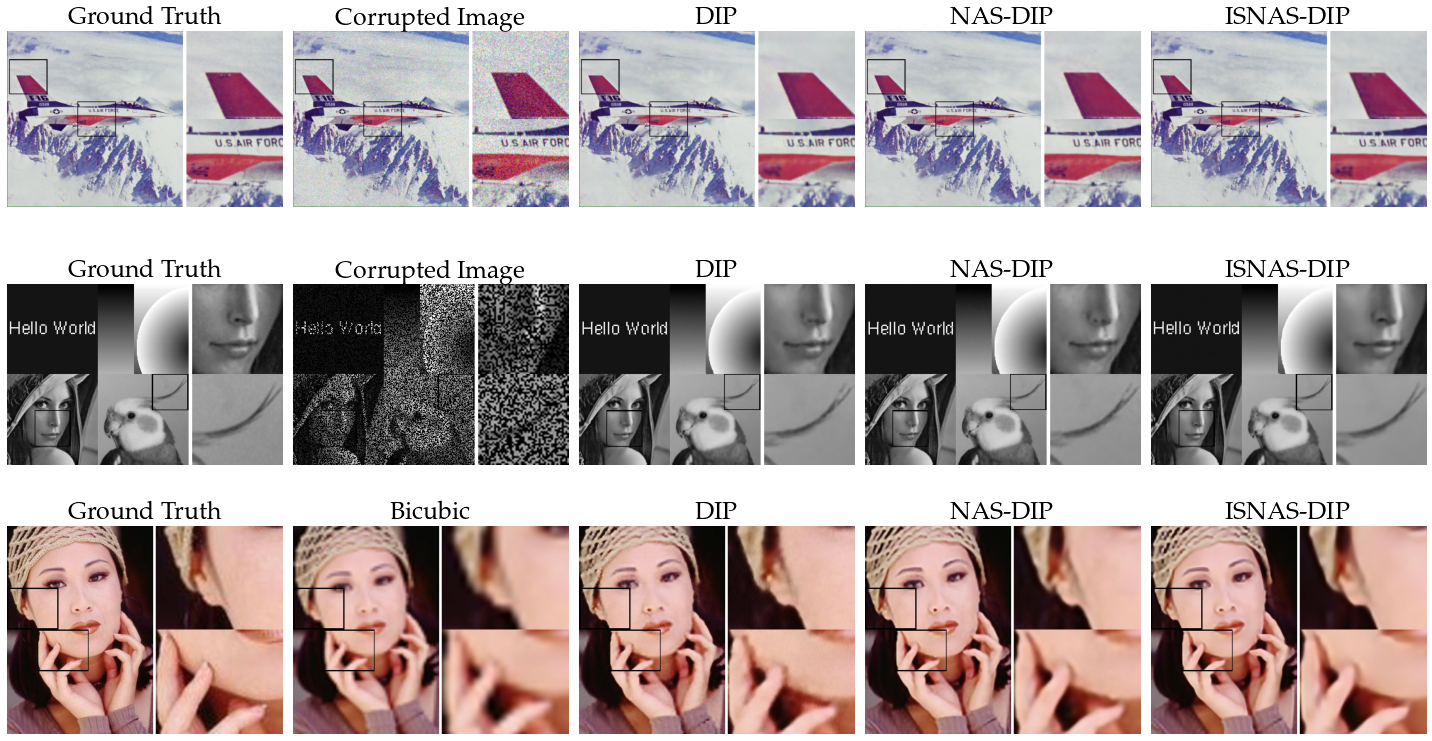

In [27]:
sigma = 25
p = 50
zoom = 4


fig, axs = plt.subplots(3, 5)
axs_f16 = axs[0, :]
axs_montage = axs[1, :]
axs_woman = axs[2, :]


# metric = 'psd db strip mse'
img_stem = 'f16_512_rgb'
metric = 'psd strip hist emd'

gt_img = bu.read_true_image(DENOISING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, sigma=sigma)
dip_img = ROOT['NASDIP Official Results'][DENOISING][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][DENOISING][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, sigma=25)
    
imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.16, 0.01),
    top_left2=(0.4, 0.4),
    size=(0.2, 0.22),
    titles=['Ground Truth', 'Corrupted Image', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs_f16,
    fontsize=25,
    location='right',
    sep_px=10,
    sep_color='white'
)


img_stem = 'montage_256'
metric = 'psd strip hist emd'

gt_img = bu.read_true_image(INPAINTING, img_stem)
ns_img, _ = bu.read_noisy_image(img_stem, p=p)

dip_img = ROOT['NASDIP Official Results'][INPAINTING][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][INPAINTING][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, p=p)

imu.qualitative_comparison(
    [gt_img, ns_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.7, 0.15),
    top_left2=(0.5, 0.80),
    size=(0.2, 0.2),
    titles=['Ground Truth', 'Corrupted Image', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs_montage,
    fontsize=25,
    location='right',
    sep_px=5,
    sep_color='white'
)


img_stem = 'woman_rgb'

metric = 'psd db mse'

gt_img = bu.read_true_image(SR, img_stem)
bic_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom]['bicubic'][f'{img_stem}.png'].load()
bic_img = imu.resize(bic_img, (gt_img.shape[1], gt_img.shape[2]))

dip_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom][DIP][f'{img_stem}.png'].load()
nasdip_img = ROOT['NASDIP Official Results'][SR]['set5'][zoom][NASDIP][f'{img_stem}.png'].load()
isnasdip_img = isnasdip_selected(img_stem, metric, zoom=zoom)

imu.qualitative_comparison(
    [gt_img, bic_img, dip_img, nasdip_img, isnasdip_img],
    top_left1=(0.3, 0),
    top_left2=(0.5, 0.21),
    size=(0.2, 0.35),
    titles=['Ground Truth', 'Bicubic', 'DIP', 'NAS-DIP', 'ISNAS-DIP'],
    axs=axs_woman,
    fontsize=25,
    location='right',
    sep_px=4,
    sep_color='white'
)


fig.set_figheight(11)
fig.set_figwidth(20)
fig.tight_layout()

# fig.savefig(
#     'data/qualitative-comparison-f16.png', facecolor='white', 
#     bbox_inches='tight'
# )